In [1]:
!pip install pandas
!pip install transformers
!pip install datasets
!pip install torch
!pip install numpy
!pip install nltk

import pandas as pd
from transformers import AutoTokenizer
from transformers import TFAutoModel
from transformers import TFAutoModelForSequenceClassification
from datasets import load_dataset
from datasets import *
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel
from transformers import AutoConfig
import torch
import numpy as np
from transformers import Trainer
import nltk



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [12]:
df = pd.DataFrame()

for i in range(0,14):
  df = pd.concat([df,pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ProjectFiles/TaggedFiles/' + str(i) + '_Tag.csv')])


In [15]:
sentences = nltk.sent_tokenize(' '.join(df['Text'].to_list()))
all_labels = df['Label'].to_list()
labels = []
for s in sentences:
    n_words = len(s.split(' '))
    sentence_labels = all_labels[:n_words]
    labels.append(sentence_labels)
    #print(s)
    #print(sentence_labels)
    all_labels = all_labels[n_words:]

In [16]:
!pip install datasets
from datasets import Dataset, DatasetDict, ClassLabel, Value, Features, Sequence

In [17]:
df2 = pd.DataFrame(zip([s.split(' ') for s in sentences], labels), columns=['tokens', 'tags'])
class_labels = list(df['Label'].unique())

In [18]:
dataset = Dataset.from_pandas(df2, features=Features({'tokens':Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
                                                      'tags': Sequence(feature=ClassLabel(names=class_labels, id=None), length=-1, id=None)}), preserve_index=False)
dataset

Dataset({
    features: ['tokens', 'tags'],
    num_rows: 1789
})

In [19]:
ds = dataset.train_test_split(test_size=0.1)
train_valid = ds['train'].train_test_split(test_size=0.1)
# gather everyone if you want to have a single DatasetDict
ds = DatasetDict({
    'train': train_valid['train'],
    'test': ds['test'],
    'valid': train_valid['test']})

ds

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 1449
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 179
    })
    valid: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 161
    })
})

In [20]:
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

In [21]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=4fab338048616fbd5247c1c68fb0e62b182047565b219b12dcbbf69cf105e64a
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [22]:
from transformers import (
    BertTokenizerFast, BertForTokenClassification,
    TrainingArguments, Trainer, DataCollatorForTokenClassification,
    EarlyStoppingCallback
)
from seqeval.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

#Tokenize and Align Labels with BERT Tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

def tokenize_and_align_labels(example):
    tokenized = tokenizer(
        example["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=128,
        return_offsets_mapping=True
    )

    labels = example["tags"]
    word_ids = tokenized.word_ids()

    aligned_labels = []
    for word_idx in word_ids:
        if word_idx is None:
            aligned_labels.append(-100)
        else:
            aligned_labels.append(labels[word_idx])

    tokenized["labels"] = aligned_labels
    del tokenized["offset_mapping"]
    return tokenized

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [23]:
encoded_dataset = ds.map(tokenize_and_align_labels, remove_columns=["tokens", "tags"])

Map:   0%|          | 0/1449 [00:00<?, ? examples/s]

Map:   0%|          | 0/179 [00:00<?, ? examples/s]

Map:   0%|          | 0/161 [00:00<?, ? examples/s]

In [24]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1449
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 179
    })
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 161
    })
})

In [26]:
import numpy as np

In [25]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=2)

    true_preds, true_labels = [], []

    for pred_seq, label_seq in zip(predictions, labels):
        temp_preds, temp_labels = [], []
        for p, l in zip(pred_seq, label_seq):
            if l != -100:
                temp_preds.append(id2label[p])
                temp_labels.append(id2label[l])
        true_preds.append(temp_preds)
        true_labels.append(temp_labels)

    print("\n Classification Report:")
    print(classification_report(true_labels, true_preds))

    return {
        "accuracy": accuracy_score(true_labels, true_preds),
        "precision": precision_score(true_labels, true_preds),
        "recall": recall_score(true_labels, true_preds),
        "f1": f1_score(true_labels, true_preds)
    }

In [28]:
args = TrainingArguments(
    output_dir="./bert_bio_model_final",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none",
    fp16=True
)


collator = DataCollatorForTokenClassification(tokenizer)

In [29]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["valid"],
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.311000,0.014848,0.996219,0.900000,0.857143,0.878049
2,0.056300,0.058062,0.990097,0.948718,0.880952,0.913580
3,0.034800,0.035740,0.992258,0.961039,0.880952,0.919255
4,0.041400,0.025882,0.991718,0.961538,0.892857,0.925926
5,0.028500,0.051804,0.990997,0.935897,0.869048,0.901235
6,0.025500,0.038181,0.986856,0.897436,0.833333,0.864198



 Classification Report:
              precision    recall  f1-score   support

      ABSENT       0.75      0.60      0.67         5
     PRESENT       0.83      0.91      0.87        11
        PROJ       0.62      0.50      0.55        16
        VOTE       1.00      0.98      0.99        52

   micro avg       0.90      0.86      0.88        84
   macro avg       0.80      0.75      0.77        84
weighted avg       0.89      0.86      0.87        84


 Classification Report:
              precision    recall  f1-score   support

      ABSENT       0.80      0.80      0.80         5
     PRESENT       0.92      1.00      0.96        11
        PROJ       0.78      0.44      0.56        16
        VOTE       1.00      1.00      1.00        52

   micro avg       0.95      0.88      0.91        84
   macro avg       0.87      0.81      0.83        84
weighted avg       0.93      0.88      0.90        84


 Classification Report:
              precision    recall  f1-score   support



TrainOutput(global_step=546, training_loss=0.08289392221541632, metrics={'train_runtime': 135.6852, 'train_samples_per_second': 213.583, 'train_steps_per_second': 13.413, 'total_flos': 567964443013632.0, 'train_loss': 0.08289392221541632, 'epoch': 6.0})

In [30]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def tag_text(text, tags, model, tokenizer):
    # Get tokens with special characters
    tokens = tokenizer(text).tokens()
    # Encode the sequence into IDs
    input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)
    # Get predictions as distribution over 7 possible classes
    outputs = model(input_ids)[0]
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    # Convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

In [31]:
tags = dataset.features["tags"].feature

tag_text('21-16 Mountain View Meadows, Major Subdivision (Extension of Approval) Doug Flynn from Lansing Engineering presented on behalf of the applicant.', tags, trainer.model, tokenizer)

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
Tokens,[CLS],21,-,16,Mountain,View,Meadows,",",Major,Sub,...,Lansing,Engineering,presented,on,behalf,of,the,applicant,.,[SEP]
Tags,O,B-PROJ,B-PROJ,B-PROJ,I-PROJ,I-PROJ,I-PROJ,I-PROJ,I-PROJ,I-PROJ,...,O,O,O,O,O,O,O,O,O,O


In [63]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # Pass data through model
        output = trainer.model(input_ids, attention_mask)
        # Logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 9),
                         labels.view(-1), reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

In [33]:
test_set = encoded_dataset["test"]
test_set = test_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = test_set.to_pandas()

Parameter 'function'=<function forward_pass_with_label at 0x7f1286419e40> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/179 [00:00<?, ? examples/s]

In [34]:
id2label[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [id2label[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [id2label[i] for i in x])
df['loss'] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[101, 3274, 1116, 1163, 4208, 119, 102, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[IGN, O, O, O, O, O, IGN, IGN, IGN, IGN, IGN, ...","[0.0, 0.0011525662, 0.0015553056, 0.0015729209...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[[CLS], Simon, ##s, said, yes, ., [SEP], [PAD]..."


In [35]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,3274,0,1,O,0.0,O,Simon
0,1116,0,1,O,0.0,O,##s
0,1163,0,1,O,0.0,O,said
0,4208,0,1,O,0.0,O,yes
0,119,0,1,O,0.0,O,.
1,10605,0,1,O,0.0,O,Lo
1,5773,0,1,O,0.0,O,##ew


In [36]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true):
    fig, ax = plt.subplots(figsize=(6, 6))
    ConfusionMatrixDisplay.from_predictions(y_true, y_preds, normalize="true", cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

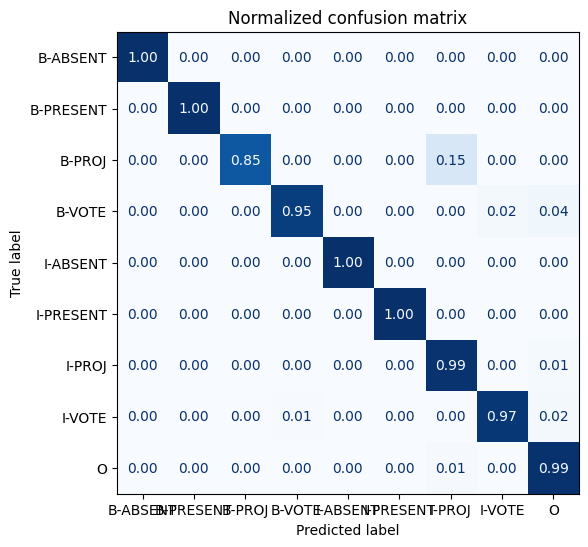

In [37]:
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"])

In [ ]:

#bert_model_name = "bert-base-uncased"
bert_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)



def align_labels(examples):
    tokenized_inputs = bert_tokenizer(examples["Text"], truncation=True,
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["Label"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["Label"] = labels
    return tokenized_inputs

In [ ]:

model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
#print(tokenizer.model_max_length)

def tokenize(batch):
    return tokenizer(batch['Text'], padding=True, truncation=True, max_length=tokenizer.model_max_length)


#theDS_encoded = testSet.map(tokenize)

In [ ]:
text1=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ProjectFiles/TaggedFiles/0_Tag.csv')
#str(x) for x in xs

exText = [' '.join(text1['Text'].to_list())]
exLabel = [','.join(str(x) for x in text1['Label'].to_list())]

In [ ]:
testingPD=pd.DataFrame()
testingPD['Text'] = exText
testingPD['Label'] = exLabel

#testingPD.to_csv('testing_PD.csv')

Load the models for use later.



In [40]:
# hide_output


bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [ ]:
bert_tokens = bert_tokenizer(exText[0]).tokens()
xlmr_tokens = xlmr_tokenizer(exText[0]).tokens()

Token indices sequence length is longer than the specified maximum sequence length for this model (5691 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5956 > 512). Running this sequence through the model will result in indexing errors


Comparing the tokens generated between BERT and XLM

In [ ]:
df = pd.DataFrame([bert_tokens, xlmr_tokens], index=["BERT", "XLM-R"])
df

,0,1,2,3,4,5,6,7,8,9,...,5946,5947,5948,5949,5950,5951,5952,5953,5954,5955
BERT,[CLS],Hall,",",with,Co,-,Chair,##person,",",Jean,...,None,None,None,None,None,None,None,None,None,None
XLM-R,<s>,▁Hall,",",▁with,▁Co,▁-,Cha,ir,person,",",...,▁Plan,ning,▁Board,▁Secretary,▁Plan,ning,▁Technic,ia,▁n,</s>


In [45]:


class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # Load model body
        # we set add_​pool⁠ing_layer=False to ensure all hidden states are returned and not only the one associated with the [CLS] token.
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Load and initialize weights
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
                labels=None):
        # Use model body to get encoder representations
        outputs = self.roberta(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids)
        # Apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return TokenClassifierOutput(loss=loss, logits=logits,
                                     hidden_states=outputs.hidden_states,
                                     attentions=outputs.attentions)

In [ ]:



class_names = ['O', 'B-PRESENT', 'I-PRESENT' , 'B-ABSENT', 'I-ABSENT' , 'B-VOTE' , 'I-VOTE', 'B-PROJ', 'I-PROJ']
ft = Features({'Tokens': Value('string'), 'Labels': ClassLabel(num_classes=9,names=class_names)})

In [ ]:
index2tag = {idx: tag for idx, tag in enumerate(class_names)}
tag2index = {tag: idx for idx, tag in enumerate(class_names)}

index2tag=id2label,
tag2index=label2id


In [ ]:
tag2index

{'O': 0,
 'B-PRESENT': 1,
 'I-PRESENT': 2,
 'B-ABSENT': 3,
 'I-ABSENT': 4,
 'B-VOTE': 5,
 'I-VOTE': 6,
 'B-PROJ': 7,
 'I-PROJ': 8}

In [ ]:
index2tag

{0: 'O',
 1: 'B-PRESENT',
 2: 'I-PRESENT',
 3: 'B-ABSENT',
 4: 'I-ABSENT',
 5: 'B-VOTE',
 6: 'I-VOTE',
 7: 'B-PROJ',
 8: 'I-PROJ'}

In [50]:
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                         num_labels=10,
                                         id2label=id2label,
                                         label2id=label2id)

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(device))

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [ ]:
from nltk.tokenize import sent_tokenize
nltk.download('punkt_tab')
sent_text = nltk.sent_tokenize(exText[0])

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


This code below is setting up the dataset to be in the correct format.  will need to loop around it for the final compilation.

In [ ]:
exTextSplit=exText[0].split(' ')
theDF = pd.DataFrame([exText[0].split(' '),exLabel[0].split(',')],index=["Tokens", "Labels"])
theDF
theDFT=theDF.T

In [ ]:
theDFT

,Tokens,Labels
0,"Hall,",O
1,with,O
2,Co,O
3,"-Chairperson,",O
4,Jean,O
...,...,...
4344,Board,O
4345,Secretary,O
4346,Planning,O
4347,Technicia,O


In [ ]:
dfDS = Dataset.from_pandas(theDFT, features=ft)

dfDS

Dataset({
    features: ['Tokens', 'Labels'],
    num_rows: 4349
})

In [ ]:
train_testvalid = dfDS.train_test_split(test_size=0.2)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict
ds = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'validation': test_valid['train']})

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["Tokens"], padding='max_length', max_length=128,
                                      is_split_into_words=False)
    print(tokenized_inputs)
    labels = []
    for label in enumerate(examples["Labels"]):
        word_ids = tokenized_inputs.word_ids()
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[1])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels,batched=True,
                        remove_columns=['Tokens','Labels'])

In [ ]:
encodedDS = encode_panx_dataset(ds)
encodedDS

Map:   0%|          | 0/3479 [00:00<?, ? examples/s]

{'input_ids': [[0, 46, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 468, 182512, 32, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 190, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Map:   0%|          | 0/435 [00:00<?, ? examples/s]

{'input_ids': [[0, 16792, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 10861, 60502, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 16934, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

Map:   0%|          | 0/435 [00:00<?, ? examples/s]

{'input_ids': [[0, 70, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 468, 182512, 32, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 4527, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3479
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 435
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 435
    })
})

In [ ]:


def align_predictions(predictions, label_ids):
    # Function to take a set of predictions and align them with a list of labels to use in the classification report
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

In [52]:
from transformers import TrainingArguments

num_epochs = 5
batch_size = 24
logging_steps = len(encoded_dataset["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-en"
training_args = TrainingArguments(output_dir=model_name,
                                  log_level="error",
                                  num_train_epochs=num_epochs,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  eval_strategy="epoch",
                                  save_steps=1e6,
                                  weight_decay=0.01,
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  report_to='none',)

In [ ]:
!pip install seqeval
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions,
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [53]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [54]:
def model_init():
    return (XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device))

In [38]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1449
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 179
    })
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 161
    })
})

In [55]:

trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=encoded_dataset["train"],
                  eval_dataset=encoded_dataset["valid"],
                  processing_class=xlmr_tokenizer)

In [ ]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [56]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.469700,0.152459,0.964530,0.000000,0.000000,0.000000
2,0.170900,0.086410,0.968131,0.058824,0.011905,0.019802
3,0.118400,0.092537,0.975513,0.750000,0.250000,0.375000
4,0.101500,0.032670,0.987216,0.731343,0.583333,0.649007
5,0.070800,0.024939,0.990817,0.816667,0.583333,0.680556



 Classification Report:
              precision    recall  f1-score   support

      ABSENT       0.00      0.00      0.00         5
     PRESENT       0.00      0.00      0.00        11
        PROJ       0.00      0.00      0.00        16
        VOTE       0.00      0.00      0.00        52

   micro avg       0.00      0.00      0.00        84
   macro avg       0.00      0.00      0.00        84
weighted avg       0.00      0.00      0.00        84



/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Classification Report:
              precision    recall  f1-score   support

      ABSENT       0.00      0.00      0.00         5
     PRESENT       0.00      0.00      0.00        11
        PROJ       0.09      0.06      0.07        16
        VOTE       0.00      0.00      0.00        52

   micro avg       0.06      0.01      0.02        84
   macro avg       0.02      0.02      0.02        84
weighted avg       0.02      0.01      0.01        84


 Classification Report:
              precision    recall  f1-score   support

      ABSENT       0.00      0.00      0.00         5
     PRESENT       0.00      0.00      0.00        11
        PROJ       0.00      0.00      0.00        16
        VOTE       0.75      0.40      0.53        52

   micro avg       0.75      0.25      0.38        84
   macro avg       0.19      0.10      0.13        84
weighted avg       0.46      0.25      0.33        84


 Classification Report:
              precision    recall  f1-score   support



/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=305, training_loss=0.18340248296983908, metrics={'train_runtime': 166.0154, 'train_samples_per_second': 43.641, 'train_steps_per_second': 1.837, 'total_flos': 473307981350400.0, 'train_loss': 0.18340248296983908, 'epoch': 5.0})

In [57]:
dfl = pd.DataFrame(trainer.state.log_history[:-1])[['epoch','loss' ,'eval_loss', 'eval_f1']]
dfl = dfl.rename(columns={"epoch":"Epoch","loss": "Training Loss", "eval_loss": "Validation Loss", "eval_f1":"F1"})
dfl['Epoch'] = dfl["Epoch"].apply(lambda x: round(x))
dfl['Training Loss'] = dfl["Training Loss"].ffill()
dfl[['Validation Loss', 'F1']] = dfl[['Validation Loss', 'F1']].bfill().ffill()
dfl.drop_duplicates()

,Epoch,Training Loss,Validation Loss,F1
0,1,0.4697,0.152459,0.000000
2,2,0.1709,0.086410,0.019802
4,3,0.1184,0.092537,0.375000
6,4,0.1015,0.032670,0.649007
8,5,0.0708,0.024939,0.680556


In [ ]:
def tag_text(text, tags, model, tokenizer):
    # Get tokens with special characters
    tokens = tokenizer(text).tokens()
    # Encode the sequence into IDs
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # Get predictions as distribution over 7 possible classes
    outputs = model(input_ids)[0]
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    # Convert to DataFrame
    preds = [tags[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])


Run the test using this second model.  The results look ok.   Using the metrics produced an error. Since the initial model was succesful, use this portion only as a comparison.

In [59]:
text_de = '21-16 Mountain View Meadows, Major Subdivision (Extension of Approval) Doug Flynn from Lansing Engineering presented on behalf of the applicant.'
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
Tokens,<s>,▁21,-16,▁Mountain,▁View,▁Me,ado,ws,",",▁Major,...,▁presente,d,▁on,▁behalf,▁of,▁the,▁applica,nt,.,</s>
Tags,O,O,O,I-PROJ,I-PROJ,I-PROJ,I-PROJ,I-PROJ,I-PROJ,I-PROJ,...,O,O,O,O,O,O,O,O,O,O
